In [189]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import (
    plot_acf, 
    plot_pacf, 
    month_plot, 
    quarter_plot
)

pd.options.display.float_format = '{:,.2f}'.format

# Check if data exists

In [127]:
DATASET_LOC = '/home/amey/repos/statistics/training/datasets'
datafiles = ['ts_orders.csv', 'ts_returns.csv', 'ts_people.csv']
existence = [os.path.exists(os.path.join(DATASET_LOC, d)) for d in datafiles]
if all(existence):
    print('Found all data files.')
else:
    print('Could not find these files:')
    _ = [print(m) for m in [datafiles[i] for (i, v) in enumerate(existence) if not v]]

Found all data files.


# Load the main data set

Examine the data structure.

In [128]:
df = pd.read_csv(os.path.join(DATASET_LOC, datafiles[0]), encoding = 'ISO-8859-1')

In [129]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,09/11/2013,12/11/2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.00,41.91
1,2,CA-2013-152156,09/11/2013,12/11/2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.00,219.58
2,3,CA-2013-138688,13/06/2013,17/06/2013,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.00,6.87
3,4,US-2012-108966,11/10/2012,18/10/2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.58,5,0.45,-383.03
4,5,US-2012-108966,11/10/2012,18/10/2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.37,2,0.20,2.52


In [130]:
df.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

In [131]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [132]:
for dc in ['Order Date', 'Ship Date']:
    df[dc] = pd.to_datetime(df[dc], format='%d/%m/%Y')

In [133]:
_ = [print(f'dtype of {dc} is {df.dtypes[dc]}') for dc in ['Order Date', 'Ship Date']]

dtype of Order Date is datetime64[ns]
dtype of Ship Date is datetime64[ns]


# Extract category-wise sales data

In [134]:
df[['Order Date', 'Category', 'Sales']].head()

,Order Date,Category,Sales
0,2013-11-09,Furniture,261.96
1,2013-11-09,Furniture,731.94
2,2013-06-13,Office Supplies,14.62
3,2012-10-11,Furniture,957.58
4,2012-10-11,Office Supplies,22.37


In [135]:
cat_sales = df[['Order Date', 'Category', 'Sales']].groupby(['Order Date', 'Category']).sum().reset_index()
cat_sales.head()

,Order Date,Category,Sales
0,2011-01-04,Office Supplies,16.45
1,2011-01-05,Office Supplies,288.06
2,2011-01-06,Office Supplies,19.54
3,2011-01-07,Furniture,"2,573.82"
4,2011-01-07,Office Supplies,685.34


## Understanding the data structure

In [136]:
cat_sales.index

RangeIndex(start=0, stop=2864, step=1)

In [137]:
assert len(cat_sales) == (cat_sales.index.stop - cat_sales.index.start)

In [138]:
_ = [print(c, type(cat_sales[c]), cat_sales[c].dtype) for c in cat_sales.columns]

Order Date <class 'pandas.core.series.Series'> datetime64[ns]
Category <class 'pandas.core.series.Series'> object
Sales <class 'pandas.core.series.Series'> float64


### How many unique months are there?

In [139]:
np.unique(np.array(cat_sales['Order Date'], 'datetime64[M]'))

array(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12'],
      dtype='datetime64[M]')

In [140]:
cat_sales.set_index('Order Date', inplace=True)
cat_sales.head()

,Category,Sales
Order Date,,
2011-01-04,Office Supplies,16.45
2011-01-05,Office Supplies,288.06
2011-01-06,Office Supplies,19.54
2011-01-07,Furniture,"2,573.82"
2011-01-07,Office Supplies,685.34


In [141]:
cat_sales.loc['2011-01-07']

,Category,Sales
Order Date,,
2011-01-07,Furniture,"2,573.82"
2011-01-07,Office Supplies,685.34
2011-01-07,Technology,"1,147.94"


Or "get all orders in Jan 2011".

In [ ]:
cat_sales.loc['2011-01']

Likewise, orders in the year 2011 can be found using `cat_sales.loc['2011']`.

### Creating a pivot table
The data has multiple entries for a single date, one each for the category sold. Time series data should have only only observation for each time value. We can achieve that by pivoting the dataframe.

In [157]:
sales_pivot = cat_sales.pivot(columns='Category', values='Sales')
sales_pivot.head()

Category,Furniture,Office Supplies,Technology
Order Date,,,
2011-01-04,NaN,16.45,NaN
2011-01-05,NaN,288.06,NaN
2011-01-06,NaN,19.54,NaN
2011-01-07,"2,573.82",685.34,"1,147.94"
2011-01-08,76.73,10.43,NaN


In [ ]:
print(f'# days in sales data = {(sales_pivot.index.max() - sales_pivot.index.min()).days}')
print(f'# rows in sales data = {len(sales_pivot)}')

In [ ]:
full_index = pd.date_range(sales_pivot.index.min(), sales_pivot.index.max())
sales_pivot.reindex(full_index, fill_value=0)

In [ ]:
sales_pivot.fillna(0, inplace=True)

### Alternate ways of aggregation
Having a `DatetimeIndex` allows us to easily roll-up data at various time scales.

#### Weekly sales

In [ ]:
sales_pivot.resample('W').sum().head()

#### Monthly sales

In [ ]:
sales_pivot.resample('ME').sum().head()

#### Yearly sales

In [ ]:
sales_pivot.resample('YE').sum()

### Creation of new variables
Time series analysis often needs creation of new variables that are functions of the 'observation' variable. We will show how they are created using the moderately sized monthly sales data.

In [ ]:
monthly_sales = sales_pivot.resample('ME').sum()

#### First difference
It takes shows the difference $X[t+1] - X[t]$ for  $t \ge 0$. Note that, unlike the `lead` or `lag` columns, the original data is not shown. 

In [ ]:
monthly_sales.diff().head()

In [ ]:
first_diff = monthly_sales.diff()
first_diff.columns = [c + ' diff' for c in first_diff.columns]

In [ ]:
monthly_sales.join(first_diff).head()

#### Percentage change
It shows $(X[t] - X[t-1])/X[t-1]$. Note that the ratio is *not* multiplied by $100$. For example, the Furniture sales dropped by $64\%$ in February 2011.

In [ ]:
monthly_sales.pct_change().head()

#### Cumulative sales

In [ ]:
monthly_sales.cumsum().head()

#### Rolling stats

In [ ]:
rolling_window = monthly_sales.rolling(6)
rolling_window.mean().dropna().head()

In [ ]:
rolling_window.std().dropna().head()

# Illustrative exercices

## Sales and profit by Segment

In [143]:
df[['Order Date', 'Segment', 'Sales', 'Profit']].head()

,Order Date,Segment,Sales,Profit
0,2013-11-09,Consumer,261.96,41.91
1,2013-11-09,Consumer,731.94,219.58
2,2013-06-13,Corporate,14.62,6.87
3,2012-10-11,Consumer,957.58,-383.03
4,2012-10-11,Consumer,22.37,2.52


We need to aggregate the metrics.

In [168]:
sales_by_segment = df[['Order Date', 'Segment', 'Sales']].groupby(['Order Date', 'Segment']).sum().reset_index()
profit_by_segment = df[['Order Date', 'Segment', 'Profit']].groupby(['Order Date', 'Segment']).sum().reset_index()

sales_by_segment.set_index('Order Date', inplace=True)
profit_by_segment.set_index('Order Date', inplace=True)

In [167]:
sales_by_segment.head(10)

,Segment,Sales
Order Date,,
2011-01-04,Consumer,16.45
2011-01-05,Home Office,288.06
2011-01-06,Consumer,19.54
2011-01-07,Consumer,19.44
2011-01-07,Corporate,12.78
2011-01-07,Home Office,"4,374.88"
2011-01-08,Consumer,87.16
2011-01-10,Consumer,40.54
2011-01-11,Corporate,54.83


In [171]:
sales_pivot = sales_by_segment.pivot(columns='Segment', values='Sales').fillna(0)
profit_pivot = profit_by_segment.pivot(columns='Segment', values='Profit').fillna(0)

In [175]:
monthly_sales = sales_pivot.resample('ME').sum()
monthly_profit = profit_pivot.resample('ME').sum()

In [178]:
monthly_sales.columns = [c + ' sales' for c in monthly_sales.columns]
monthly_profit.columns = [c + ' profit' for c in monthly_profit.columns]

In [179]:
monthly_sales.head()

,Consumer sales,Corporate sales,Home Office sales
Order Date,,,
2011-01-31,"6,637.15","1,701.53","5,607.55"
2011-02-28,"3,458.52","1,183.67",168.37
2011-03-31,"11,869.30","11,106.80","32,714.91"
2011-04-30,"9,108.61","14,131.73","5,055.00"
2011-05-31,"12,819.16","9,142.00","1,687.12"


In [180]:
monthly_profit.head()

,Consumer profit,Corporate profit,Home Office profit
Order Date,,,
2011-01-31,762.81,300.91,"1,383.05"
2011-02-28,500.29,307.30,58.14
2011-03-31,597.28,333.05,-431.60
2011-04-30,"1,155.08","1,393.38",940.38
2011-05-31,698.92,"2,063.50",-23.71


## Solution

In [186]:
consolidated = monthly_sales.join(monthly_profit, how='outer')

In [187]:
consolidated.head()

,Consumer sales,Corporate sales,Home Office sales,Consumer profit,Corporate profit,Home Office profit
Order Date,,,,,,
2011-01-31,"6,637.15","1,701.53","5,607.55",762.81,300.91,"1,383.05"
2011-02-28,"3,458.52","1,183.67",168.37,500.29,307.30,58.14
2011-03-31,"11,869.30","11,106.80","32,714.91",597.28,333.05,-431.60
2011-04-30,"9,108.61","14,131.73","5,055.00","1,155.08","1,393.38",940.38
2011-05-31,"12,819.16","9,142.00","1,687.12",698.92,"2,063.50",-23.71


## Visualisation of sales and profits

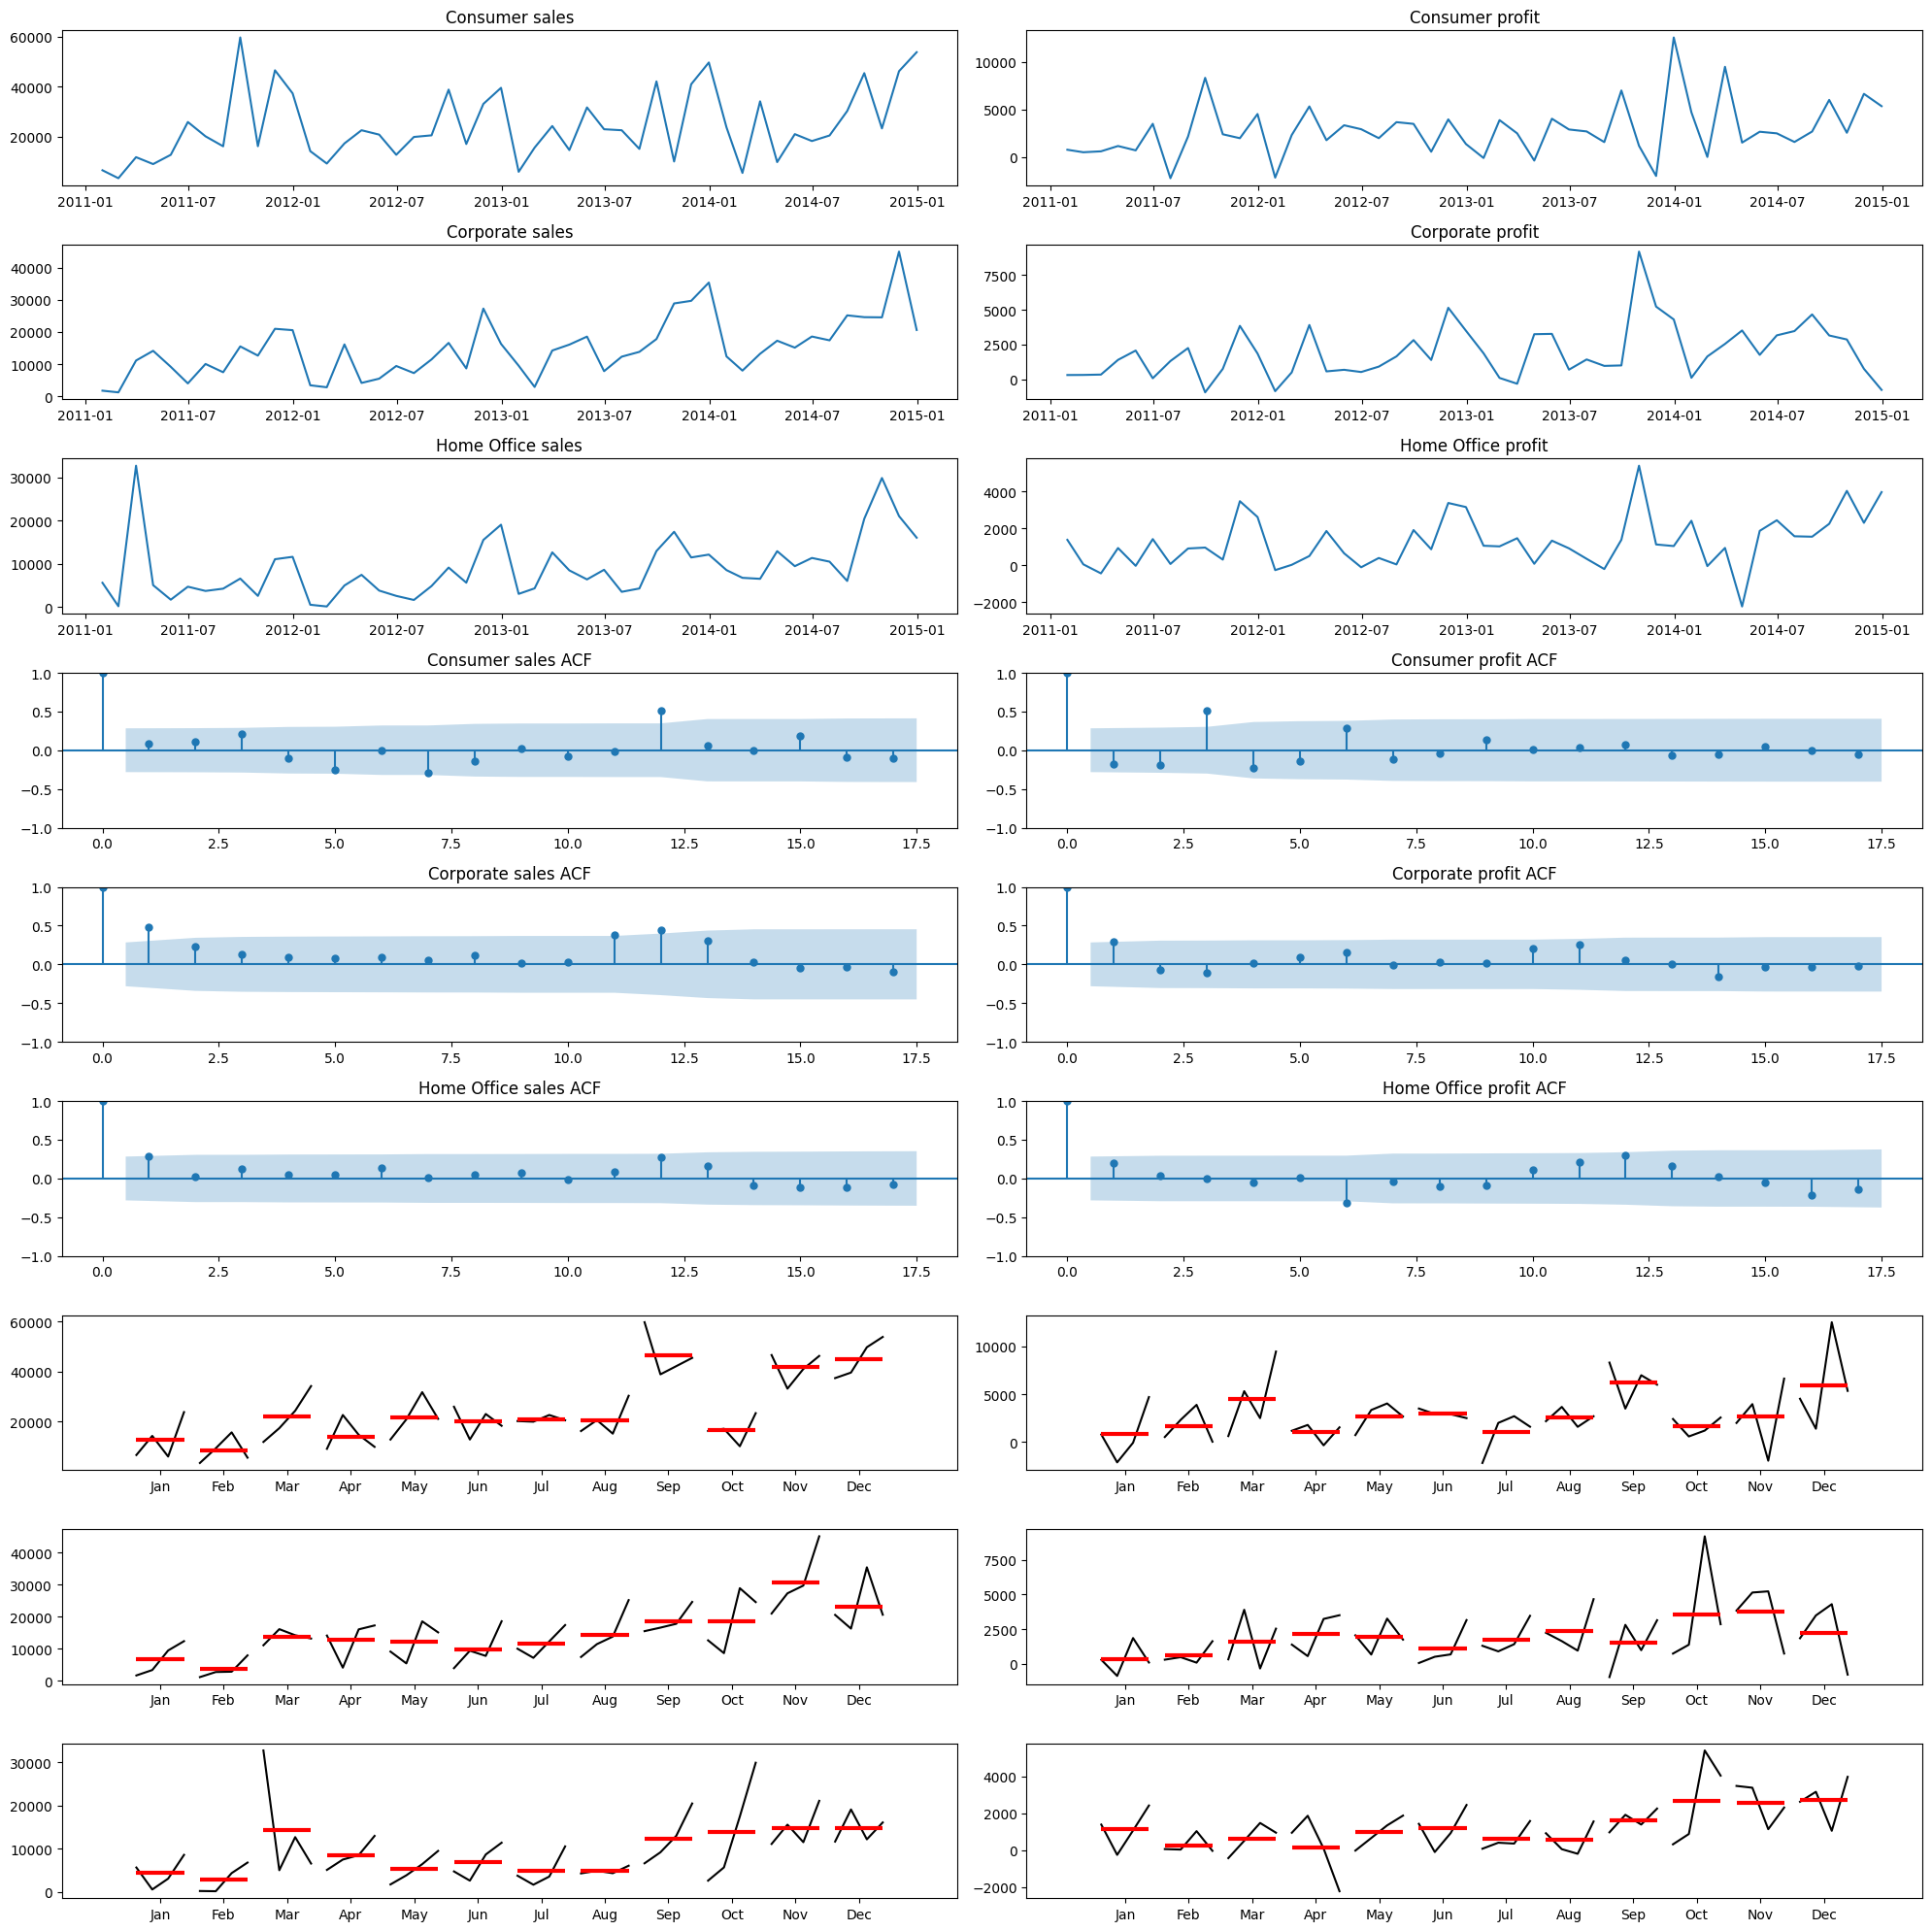

In [194]:
segments = ['Consumer', 'Corporate', 'Home Office']
metrics = ['sales', 'profit']
fig, axes = plt.subplots(9, 2, figsize=(20, 20))

for i, s in enumerate(segments):
    for j, m in enumerate(metrics):
        colname = f'{s} {m}'
        axes[i,j].plot(consolidated[colname])
        axes[i,j].title.set_text(colname)
        plot_acf(consolidated[colname], ax=axes[i + 3, j], title = colname + ' ACF')
        month_plot(consolidated[colname], ax=axes[i + 6, j], title = colname + ' month plot')

fig.tight_layout()
plt.show()